This notebook provides an implemetation of the MWU Kirszbraun algrorithm as discribed in our paper [] (TBD).
the algorthim evalutes a non parametric function $f:X \rightarrow Y$ by a consistent lischitz function. for more details please read []. The algorithm works in two phases:
1. Smoothing - where we evaluate the training points, based on seeing data X_train,Y_train, so they fit a smooth lipschitz funtion. The Lischitz constant is picked using a cross validation search on several candidates.
2. Extension. Based on the smoothing, each new point can be evaluated in a way that the lipschitz constant is reserved. 

you can run this code on eithe "cpu" or "gpu".


We start by import crucial packages, make sure you have them installed.

In [1]:
import torch
import time
import pandas as pd
import numpy as np
from math import ceil,log,pi,inf,cos,sin,sqrt

from IPython.core.debugger import Tracer;

## 1. Smoothing##
Smoothing finds an evaluation of the X_train data, such that keep a fixed Lipschitz constant, that minimze the overall loss of the observed data Y_train.  $\Phi(\tilde{Y},Y) = \frac{1}{n}\sum_{i=1}^n ||y_i-\tilde{y_i}||$.
fixing the Lipshitz constant, allow us to prevent over fitting.
The main algorithm is in SmoothMWU. FindSolutionAndReport and Smooth functions are wrapping of the algorithms.

In [2]:
gpu_num = 0
device = torch.device(f"cuda:{gpu_num}" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
if torch.cuda.is_available():
    print(f"{torch.cuda.get_device_name(gpu_num)}")

eps = 0.1 #epsilon - the precision


# the running time can improved by a factor of 2
# since we don't have to compute both |y_i - y_j| and |y_j - y_i|
def PairwiseSqDistances(Y):
    #Y is is an N-by-dimB matrix
    [N, dimB] = list(Y.size())

    repY  = Y.unsqueeze(1).expand(N, N, dimB)
    repYt = repY.transpose(0, 1)
    return torch.sum((repY - repYt) ** 2, 2)

def findLipschitzConstant(X,Y):
    """
    given two sets of vectors of size n where f(X_i) = Y_i
    finds the Lipschitz constant of f over (X,Y). 
    """
    
    return (torch.max(PairwiseSqDistances(Y) / (PairwiseSqDistances(X)+torch.eye(X.size()[0],device = device)))).to(device)

def SmoothMWU(Y, R_sq, Phi_0):
    # Y is an N-by-dimB matrix; Y^T from the write-up
    # R_sq is is an N-by-N matrix    
#    from IPython.core.debugger import Tracer; Tracer()()
    [N, dimB] = list(Y.size())
    
    m = N*(N-1) // 2 # the number of pair of points,
    delta = eps / (2*m) #what is delta

    # Initialize the weight matrix    
    w_Phi = 0.5
    W = torch.Tensor(N,N).to(device).fill_(0.5 / m)
    for i in range(N):
        R_sq[i,i] = 1 # why?

    T = 350# for better resalts use sqrt(m)*log(N)/eps**2)

    YSmoothed = torch.zeros(N, dimB, device = device) # returned output. initial guess

    for t in range(T):
        lambda_inv = Phi_0 / (w_Phi + eps/2) ## \lambda^{-1}           

        # set off-diagonal entries

        L = -lambda_inv * torch.div(W + delta, R_sq)
        
        # set/fix the diagonal entries
        S = torch.sum(L, dim = 1)
        for i in range(N):
            L[i,i] += -S[i] + 1

        # solve for Yt ; gesv ==> solve in the next version of torch
        Yt, _ = torch.gesv(Y, L)  
        YSmoothed *= t/(t+1)
        YSmoothed += Yt/(t+1)

        # update the weights
        # first update W, that is w_{ij}'s 
        PD = PairwiseSqDistances(Yt)
        WUpdate = 1 + 2*eps * (torch.div(PD, R_sq) ** 0.5 - 1)
        W *= WUpdate

        # now update w_Phi
        WPhiUpdate = 1 + 2*eps * ((torch.sum((Y - Yt) ** 2) / Phi_0) ** 0.5  - 1) 
        w_Phi *= WPhiUpdate        
               
        # renormalize
        for i in range(N):
            W[i,i] = 0

        TotalW = torch.sum(W) / 2 + w_Phi
        W /= TotalW
        w_Phi /= TotalW

    return YSmoothed
        
def Smooth(Y, R_sq):
    [N, dimB] = list(Y.size())
    YMean = (torch.sum(Y, dim = 1) / N).unsqueeze(1).expand(N, dimB)

    Phi_0 = torch.sum((Y - YMean) ** 2) #a very crude upper bound
    
    PhiUB = Phi_0
    PhiLB = 0
    
    while (PhiUB > (1 + eps/10) * PhiLB):
        print("<", end = "")
        Phi_0 = (PhiLB + PhiUB) / 2
        YSmoothed = SmoothMWU(Y, R_sq, Phi_0)
        bLip = ( PairwiseSqDistances(YSmoothed) < (1 + eps) * R_sq ).all()
        bPhi = (torch.sum((Y - YSmoothed) ** 2) / Phi_0) < 1 + 2 * eps

        if bLip and bPhi:
            PhiUB = Phi_0
        else:
            PhiLB = Phi_0   
        print(">", end = "", flush = True)         
 
    print()
    return SmoothMWU(Y, R_sq, PhiUB)

def FindSolutionAndReport(Y, X,Lip, bReportVectors=True):
    R_sq = PairwiseSqDistances(X)
    StartTime = time.time()
    YSmoothed = Smooth(Y,Lip * R_sq)
    phi = torch.mean((Y - YSmoothed) ** 2).item()
    d,n = X.size()[1]+Y.size()[1],X.size()[0] # important for risk bound using Rademacher complexity
    k = ( (d-1)*34*(4*Lip)**(d/2) ) / ( 2*sqrt(n) )
    rad = 8*k**(1/(d+1)) + d*k**((d-1)/(d+1)) - 2*(-(d+1)/2)
    rad_bound = phi+rad
    print("Phi: ", phi, " Rad:", rad, " Bound: ",rad_bound)
    print("Lipschitz constant ",findLipschitzConstant(X,YSmoothed))
    if bReportVectors:
        print("vectors:", YSmoothed)

    print("Elapsed time", round(time.time()- StartTime,2), " sec")
    return YSmoothed, rad_bound

Running on cpu


## 2. Extension ##
The extension evaluate a new point $x \in X$ that preserved the lipschitz constant of the Z_train set 

In [3]:
def nearestNeighbor(x,X,Y):
#NEARESTNEIGHBOR finds the nearest neighbor and it's distance
#   x - a vector
#   X - group of vectors represented as row vectors.
#   returns the nearest neigbor of x in X, the ditance ||x-nn||, and
#   y0=f(x0)

    N = X.size()[0]; # number of vectors in X
    difference = torch.norm(X-x.repeat(N,1),dim=1)
    dist,i = torch.min(difference),torch.argmin(difference)
    nn = X[i,:]
    y0 = Y[i,:]
    return dist,y0

def extension(x,X,Y,eps,L):
    # extension finds a (1+eps) Lipshitz approximation for z=h(x)
    #   x = the query point (vector)
    #   X = the training set samples
    #   Y = the training set labeling (not the true lables). actualy Y=Z
    #   eps = the approximation parameter. in (0,1/2)
    #   z = the output , the extension of h to x. z=h(x) s.t the lipshitz
    #   constnant is less then (1+eps)L
    ## the marks numbers are for being consistent with the paper of the work.
    
    # basic parameters
    n = X.size()[0]; # sample size
    DOF2 = Y.size()[1] # dimension of Y 
    
    #1. find nearest neighbour of x out of X; y0 = f(x0) ; d0 = ||x0-x||
    d0,y0 = nearestNeighbor(x,X,Y)
    #2. T is nuber of iterations
    T = 1000 # for better results use torch.min(ceil(16*log(n)/eps**2)
    #3. initialize weights vector w where w1=1/n for each i
    w = torch.ones(n,T+1).to(device)*1/n;
    #4. initialize distance vector d where di = ||xi - x||
    d = L*torch.norm(X-x.repeat(n,1),dim=1)
    #5. Steps 6-10 will be repeated until convergence
    for t in range(T):
        #6. create a distribution
        P = torch.sum(w[:,t]/(d**2)); #normaplization parameter
        p = w[:,t]/(P*(d**2));
        #7. z0 = sum(pi*yi) and delta = ||z0-y0||
        z0 = torch.sum(Y*p.repeat(DOF2,1).transpose(0,1),dim=0)
        delta = torch.norm(z0-y0);
        #8. evalute z
        if delta <= d0:
            z = z0
        else:
            z = d0/delta*z0+(delta-d0)/delta*y0
        #9. update weights : wi(t+1) = (1+(eps*||z-yi||/8di))*wi(t) for all i 
        tmp_dist = torch.norm(z.repeat(n,1)-Y,dim=1)
        w[:,t+1]=torch.ones(n,device=device)+eps*tmp_dist/(8*d)*w[:,t]        
        #10. normalize the weitghts
        W = torch.sum(w[:,t+1]);
        w[:,t+1] = (1/W)*w[:,t+1];
    #11. average over weights
    final_w = torch.sum(w,dim=1)*1/(T+1);
    #12. compute z as in 6-8
    #6. 
    P = torch.sum(final_w*(d**2)); #normaplization parameter
    p = final_w/(P*(d**2));
    #7. z0 = sum(pi*yi) and delta = ||z0-y0||
    z0 = torch.sum(Y*p.repeat(DOF2,1).transpose(0,1),dim=0)
    delta = torch.norm(z0-y0);
    #8. evalute z
    if delta <= d0:
        z = z0
    else:
        z = d0/delta*z0+(delta-d0)/delta*y0
    return z

def Test(X_val,X_train,Z_train,eps,l):
    n_val = X_val.size()[0] # validation/test set size
    DOF2 = Z_train.size()[1];    # dimension of Y, the second agent
    Z_val = torch.ones(n_val,DOF2).to(device)
    for i in range(n_val):
        x0 = X_val[i]
        Z_val[i] = extension(x0,X_train,Z_train,eps,l)
    return Z_val

## 3. Train and Test
the next section is for using the algorithm in order to train and test the algorithm.
The training consist of finding the optimal Lipshchitz $l$ constant using cross validation over different $l$ candidates.
We also used the Structur Risk Minimization (SRM) which finds the $l$ which yields to the smallest generalization bound, but in practice this factor is non informative unless n is on a very large scale (milions). 
It is likely the SRM will be deleted in future for now you can uncomment it for your own use

In [4]:
def lstsqrs(Z,Y):
    ### will return the distance phi = sum(||Z-Y||**2)
    ### when dealing with angels we notice that distance(0,2pi) = 0
    N = Z.size()[0]
    return torch.sum(torch.norm(Z-Y,dim=1)**2)/N


#mod_lstqr consider the periodic of distance between angles
def mod_lstsqr(Z,Y):
    ### will return the distance phi = sum(||Z-Y||**2)
    ### when dealing with angels we notice that distance(0,2pi) = 0
    diff = torch.min((Z-Y)%(2*pi),(Y-Z)%(2*pi))
    dist = torch.norm(diff,dim=1)**2
    return dist.mean()
    
def crossVal(X,Y,X_val,Y_val,k_fold = 10,CV = True, RAD = False):
    #basic parameters
    N,DOF1 = X.size();
    DOF2 = Y.size()[1];
    N_val = X_val.size()[0]
    lip = findLipschitzConstant(X,Y)
    L = torch.exp(torch.linspace(0,torch.log(lip),k_fold))
    StartTime = time.time()
    
    #important values
    
    if CV:
        stop_cond  = True
        lip_const  = inf #the returned lipschitz constant of the CV process
        Phi = inf # the returned score score sum(||Y_i-Z_i||)/N , 
        Z_train_cv = torch.zeros(Y.size()), #the returned smoothing
    
#    if RAD: #if you choose use Rademacher complexity generalization bounds
#        stop_cond_rad  = True
#        lip_const_rad = inf
#        rad = inf
#        Z_train_rad = torch.zeros(Y.size())
        
    for l in L:
        tmp_time = time.time()
        Z_train_l,rad_l = FindSolutionAndReport(Y,X,l,False) # smoothig by l
        Z_val_l = Test(X_val,X,Z_train_l,eps,l) # validating
        Phi_l = lstsqrs(Z_val_l,Y_val) # l_smoothing scoretorch.sum((Z_val_l - Y_val) ** 2).item() #
        if CV and Phi_l < Phi:
            Phi = Phi_l
            lip_const = l
            Z_train = Z_train_l
            stop_cond = False
            
#        if RAD and rad_l < rad:
#            rad = rad_l
#            lip_const_rad = l
#            Z_train_rad = Z_train_l
#            stop_cond_rad = False
            
        else:
            if stop_cond: # if it is the second time it means we start over fitting so we stop
                print("lip ",l," Phi = ",Phi_l, "time = ", round(time.time()- tmp_time,2), "sec")
                print("We start overfitting the data")
                break
            stop_cond = True
        print("lip ",l," Phi = ",Phi_l, "time = ", round(time.time()- tmp_time,2), "sec")
    print("finished training ",N," points ",k_fold,"crossValidation in ",round(time.time()- StartTime,2)," sec")
    if CV: print("Lip_const_cv: l=", lip_const," with score: Phi=",Phi)
#    if RAD: print("Lip_const_rad:l=", lip_const_rad," with generalization bound: ",rad)
    
    return Z_train_cv,lip_const

For Testing our model, we first import the data, which should be allocated in a directory named data - placed in the same directory as this code file

In [5]:
N_train = 10000
N_val = 100
N_test = 1000
data_dir = 'data_3to5'
X_train = torch.Tensor(np.array(pd.read_excel(data_dir+'\X_train.xlsx', header = None))[:N_train,:]).to(device)
X_val = torch.Tensor(np.array(pd.read_excel(data_dir+'\X_val.xlsx', header = None))[:N_val,:]).to(device)
X_test = torch.Tensor(np.array(pd.read_excel(data_dir+'\X_test.xlsx', header = None))[:N_test,:]).to(device)
Y_train = torch.Tensor(np.array(pd.read_excel(data_dir+'\Y_train.xlsx', header = None)%(2*np.pi))[:N_train,:]).to(device)
Y_val = torch.Tensor(np.array(pd.read_excel(data_dir+'\Y_val.xlsx', header = None)%(2*np.pi))[:N_val,:]).to(device)
Y_test = torch.Tensor(np.array(pd.read_excel(data_dir+'\Y_test.xlsx',header = None)%(2*np.pi))[:N_test,:]).to(device)

For thousands of points running time of FindAndReport could be in hours. therefor we find the Lipschitz constant via Cross valditaion over only part of the training set. Once we picked the lip_const of the problem, we train the can smooth the entire training set.

In [6]:
CV_N = 1000
Z_train,lip_const = crossVal(X_train[:CV_N],Y_train[:CV_N],X_val,Y_val,k_fold=10)

<><><><><><><><><>
Phi:  3.410456418991089  Rad: tensor(1700.3867)  Bound:  tensor(1703.7971)
Lipschitz constant  tensor(1.0963)
Elapsed time 864.46  sec
lip  tensor(1.)  Phi =  tensor(11.8481) time =  1028.73 sec
<><><><><><><><><>
Phi:  2.750499725341797  Rad: tensor(30262.4277)  Bound:  tensor(30265.1777)
Lipschitz constant  tensor(2.7792)
Elapsed time 1209.8  sec
lip  tensor(2.5346)  Phi =  tensor(11.1990) time =  1390.24 sec
<><><><><><><><><><>
Phi:  1.947457194328308  Rad: tensor(545794.5000)  Bound:  tensor(545796.4375)
Lipschitz constant  tensor(7.0493)
Elapsed time 1309.9  sec
lip  tensor(6.4240)  Phi =  tensor(10.9282) time =  1488.92 sec
<><><><><><><><><><><>
Phi:  1.1049939393997192  Rad: tensor(9853319.)  Bound:  tensor(9853320.)
Lipschitz constant  tensor(17.9098)
Elapsed time 1435.1  sec
lip  tensor(16.2821)  Phi =  tensor(11.5924) time =  1614.23 sec
<><><><><><><><><><><><>
Phi:  0.42717188596725464  Rad: tensor(1.7790e+08)  Bound:  tensor(1.7790e+08)
Lipschitz const

In [ ]:
Z_train =  FindSolutionAndReport(Y_train,X_train,lip_const,False)

In [ ]:
startTime = time.time()
Z_test = Test(X_test,X_train,Z_train,eps,lip_const)
print("Test ",Z_test.size()[0],"samples in ",  round(time.time()- startTime,2)," sec.")

Use the following code if you already run the algorithm and\or want to save time for the exploration part

In [12]:
Z_train = torch.Tensor(np.array(pd.read_excel(data_dir+'\Z_train.xlsx', header = None))[:N_train,:]).to(device)
Z_test = torch.Tensor(np.array(pd.read_excel(data_dir+'\Z_test_mw.xlsx', header = None))[:N_test,:]).to(device)

Let's see how we did.

In [13]:
print("lstsqrs: ",lstsqrs(Z_test,Y_test))
print("mod_sqrs: ", mod_lstsqr(Z_test,Y_test))

lstsqrs:  tensor(17.3162)
mod_sqrs:  tensor(3.2505)


## 4 . comparison
To see how well the algorithm performed we compare it with a multi SVR competitor using a Gausian kernel.
The competitor is a simply a multiple regressors $g_i:X\rightarrow Y_i$, where $Y_i$ is the i coordinate of Y.
Meaning, let $x\in X$ and k be the dimension of $y \in Y$ $g(x) = (g_1(x),...,g_k(x))$.
Unlike the MWU implementation, this section is not modular in the dimensionality of $Y$, thus adding more regressors might be needed

In [14]:
from sklearn.svm import SVR
from sklearn import preprocessing

For using sklearn lib we need to make sure all our data can be used with "cpu"

In [15]:
g1,g2,g3,g4 = SVR(gamma='scale', epsilon=eps),SVR(gamma='scale', epsilon=eps),SVR(gamma='scale', epsilon=eps),SVR(gamma='scale', epsilon=eps)
Y_train1 = Y_train[:,0].to("cpu")
Y_train2 = Y_train[:,1].to("cpu")
Y_train3 = Y_train[:,2].to("cpu")
#Y_train4 = Y_train[:,3]

In [16]:
g1.fit(X_train.to("cpu"),Y_train1)
g2.fit(X_train.to("cpu"),Y_train2)
g3.fit(X_train.to("cpu"),Y_train3)
#g4.fit(X_train,Y_train4)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [17]:
Z1 = g1.predict(X_test.to("cpu"))
Z2 = g2.predict(X_test.to("cpu"))
Z3 = g3.predict(X_test.to("cpu"))

In [18]:
Z_SVR = np.concatenate((Z1,Z2,Z3)).reshape(-1,N_test).transpose()

In [19]:
Z_SVR = torch.Tensor(Z_SVR)

In [20]:
print("SVR mod_sqrs: ",mod_lstsqr(Z_SVR,Y_test))
print("MW mod_sqrs: ", mod_lstsqr(Z_test,Y_test))
print()
print("SVR lstsqrs ", lstsqrs(Z_SVR,Y_test))
print("MW lstsqrs", lstsqrs(Z_test,Y_test))

SVR mod_sqrs:  tensor(5.9299)
MW mod_sqrs:  tensor(3.2505)

SVR lstsqrs  tensor(10.3713)
MW lstsqrs tensor(17.3162)


We can see that the absolute distance between angles learned by SVR is lower - we will see in short that this is not the case for the final positions learned by the two learners. The next code is for a case you want to save your results for later use

In [21]:
df_train_mw = pd.DataFrame(np.array(Z_train))
df_test_mw = pd.DataFrame(np.array(Z_test))
df_test_SVR = pd.DataFrame(np.array(Z_SVR))

In [ ]:
df_train_mw.to_excel("tmp\Z_train.xlsx", header=None, index=None)
df_test_mw.to_excel("tmp\Z_test_mw.xlsx", header=None, index=None)
df_test_SVR.to_excel("tmp\Z_test_SVR.xlsx", header=None, index=None)

## plot

In [22]:
import matplotlib.pyplot as plt
import matlab.engine
eng = matlab.engine.start_matlab()

we now prepare the data so we can call the matlab fucntions which we use to create the data, and then use vectize function to get the 2d position of each sample. As we use a lot of different libraries there will be a lot of format chainging. keep on track. 

Matlab use only double so we must convert everything to double arrays

In [23]:
lx=np.array(pd.read_excel(data_dir + '\lx.xlsx' ,header = None))[0] #.to(device)
ly=np.array(pd.read_excel(data_dir + '\ly.xlsx' ,header = None))[0] #.to(device)

tmpX_tr = matlab.double(X_train.numpy().tolist()) #might need to change by .to('cpu')
tmpY_tr = matlab.double(Y_train.numpy().tolist())
tmpZ_tr = matlab.double(Z_train.numpy().tolist())
tmpX_test = matlab.double(X_test.numpy().tolist())
tmpY_test = matlab.double(Y_test.numpy().tolist())
tmpZ_test = matlab.double(Z_test.numpy().tolist())
tmpZ_svr = matlab.double(Z_SVR.numpy().tolist())
lx_tmp = matlab.double(lx.tolist())
ly_tmp = matlab.double(ly.tolist())

In [24]:
posX_tr = eng.vectorize(tmpX_tr,lx_tmp)
posY_tr = eng.vectorize(tmpY_tr,ly_tmp)
posZ_tr = eng.vectorize(tmpZ_tr,ly_tmp)
posX_test = eng.vectorize(tmpX_test,lx_tmp)
posY_test = eng.vectorize(tmpY_test,ly_tmp)
posZ_test = eng.vectorize(tmpZ_test,ly_tmp)
posZ_svr = eng.vectorize(tmpZ_svr,ly_tmp)

comparison by positions:
lstsqrs expect tensors. So we have to convert. also we don't need matlab's engine any more


In [25]:
eng.exit()

In [26]:
print("SVR lstsqrs ", lstsqrs(torch.Tensor(posZ_svr),torch.Tensor(posY_test)))
print("MW lstsqrs", lstsqrs(torch.Tensor(posZ_test),torch.Tensor(posY_test)))

SVR lstsqrs  tensor(2.0263)
MW lstsqrs tensor(0.5014)


We can see the MW learner beats the SVR also in the final positions (where it matters), ploting the learned correspondence will emphasis this result.
We will plot 4 arms on the same figure:
1. Black = x. the arm of the expert. 5 degrees of freedom.
2. Yellow = y. The true, *unknown* correspondence of the learner. It can easily spotted the the end frame of the learner and expert should always coinside. 3 degrees of freedom
3. Blue = z_mw The learned correspondence by the MWU learner.
4. Red = z_svr. The learned correspondence by the SVR learner.

In [28]:
def plotArms(arm1,arm2,arm3,arm4):
    x1,y1 = arm1[0::2],arm1[1::2]
    x2,y2 = arm2[0::2],arm2[1::2]
    x3,y3 = arm3[0::2],arm3[1::2]
    x4,y4 = arm4[0::2],arm4[1::2]
    plt.plot(x1,y1,'k-',x2,y2,'y-',x3,y3,'b-',x4,y4,'r')

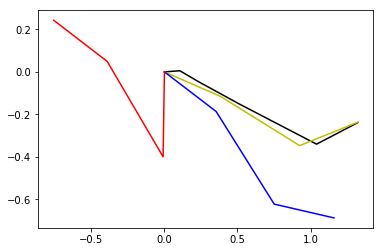

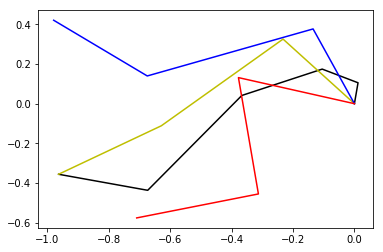

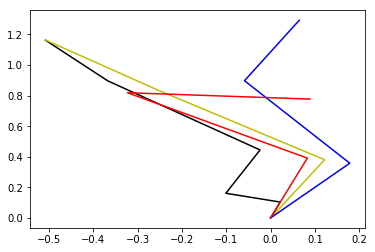

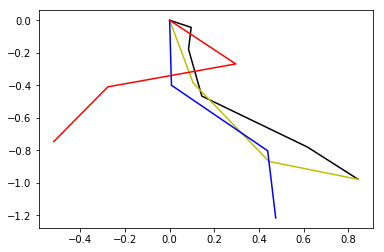

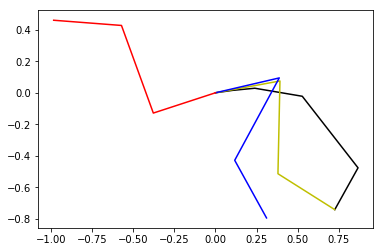

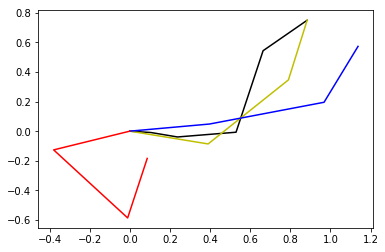

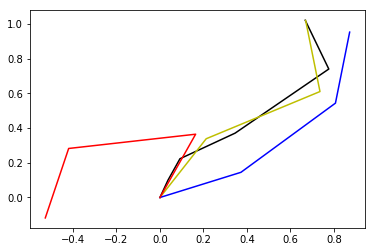

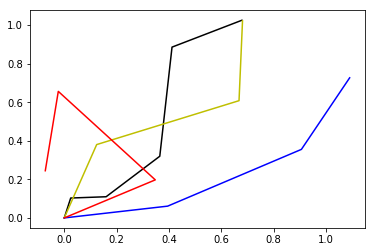

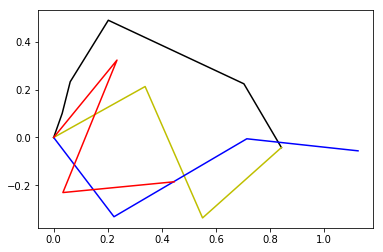

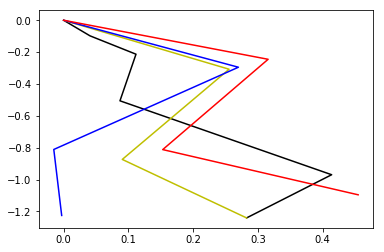

<Figure size 432x288 with 0 Axes>

In [29]:
num_of_examples = 10; # change for as much figures you want to plot
for i in range(num_of_examples):
    plotArms(posX_test[i],posY_test[i],posZ_test[i],posZ_svr[i])
    plt.show()
    plt.clf()